In [426]:
import numpy as np
import pandas as pd
import sys
import talib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style({'axes.spines.right': False, 'axes.spines.top': False,
               'axes.grid': True, 'grid.color': '.95', 'xtick.bottom': True, 'ytick.left': True})
#sns.set_palette("GnBu_d",1)

#sns.reset_orig()

In [427]:
#jd_data = pd.read_csv("JustDial.csv")
#jd_data_new = pd.read_csv("JustDial_newind.csv")
jd_data_new = pd.read_csv("GOG.csv")

In [428]:
#jd_data_new.describe()
#jd_temp_data = jd_data_new[-(375*30):]
jd_temp_data = jd_data_new
#jd_temp_data.head()

In [429]:
jd = jd_temp_data.copy()
#jd = jd.drop("DateTime", axis=1)
#jd = jd.drop("volume", axis=1)
jd = jd.drop(["Date","Adj Close", "Volume"], axis=1)
jd = jd.rename(columns = {"Open":"open","Close":"close","High":"high","Low":"low"})

jd.head()

,open,high,low,close,close_sma,bb,rsi
0,242.212219,247.622620,241.496490,246.251251,0.961991,0.132604,32.085521
1,244.744751,245.840836,243.248245,243.418411,0.961991,0.132604,32.085521
2,242.082077,245.180176,240.490494,243.038040,0.961991,0.132604,32.085521
3,244.509506,247.597595,243.258255,245.505508,0.961991,0.132604,32.085521
4,245.465469,245.680679,241.016022,241.316315,0.961991,0.132604,32.085521


(1752, 10)


,open,high,low,close,close_sma,bb,rsi,O-C,std_10,desc
0,225.225220,229.134140,225.225220,227.537537,0.961991,0.132604,32.085521,2.312317,7.672039,1
1,228.258255,228.858856,225.445450,225.715714,0.961991,0.132604,32.085521,-2.542541,7.690252,0
2,226.506500,230.225220,224.049042,229.644638,0.961991,0.132604,32.085521,3.138138,7.238744,1
3,229.804810,230.110107,226.436432,226.571579,0.961991,0.132604,32.085521,-3.233231,6.717645,1
4,225.280273,227.662659,224.224228,225.235229,0.961991,0.132604,32.085521,-0.045044,5.035124,0


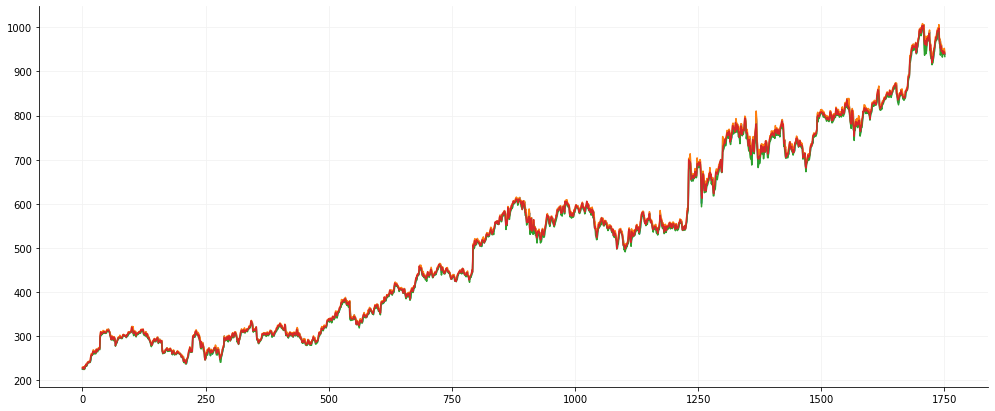

In [430]:
#jd['H-L'] = jd['high'] - jd['low']
jd['O-C'] = jd['close'] - jd['open']
#jd['sar'] = talib.SAR(np.array(jd['high']), np.array(jd['low']), 0.2, 0.2)
#jd['ma_5'] = jd['close'].rolling(window=5).mean()
#jd['ma_10'] = jd['close'].rolling(window=10).mean()
#jd['EWMA_12'] = jd['close'].ewm(span=12).mean()
#jd['std_5'] = jd['close'].rolling(window=5).std()
jd['std_10'] = jd['close'].rolling(window=10).std()
    
#0->buy, 1->sell
jd['desc'] = np.where(jd['close'].shift(-1) > jd['close'], 0, 1)

jd = jd.dropna()
jd.index = np.arange(len(jd))

plt.figure(figsize=(17,7))
#jd.iloc[:,0:4].plot()
#plt.legend()
plt.plot(jd.iloc[:,0:4])

print(jd.shape)
jd.head()

351


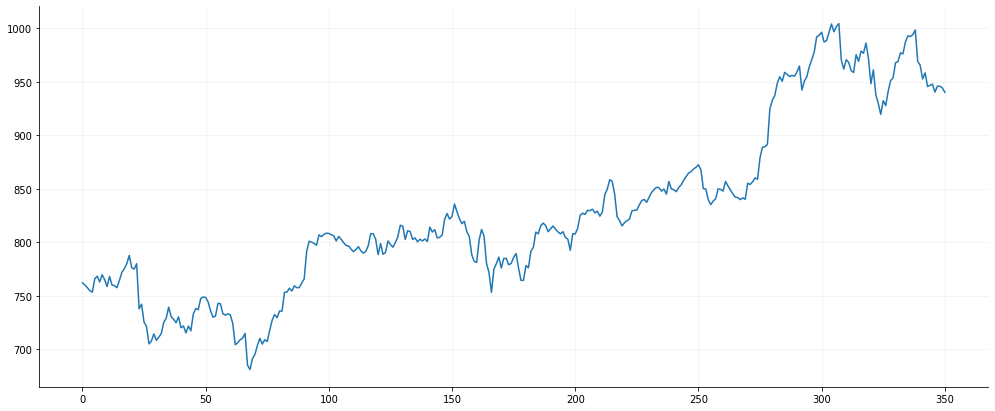

In [431]:
from sklearn.preprocessing import StandardScaler

X = jd.iloc[:, 3:-1]
y = jd.iloc[:, -1]


split = int(len(jd)*0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

temp = jd.iloc[split:,3]
temp.index = np.arange(len(temp))
print(len(temp))
    
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

plt.figure(figsize=(17,7))
#jd.iloc[split:,0:4].plot()
#plt.show()
plt.plot(temp)

In [432]:
#helper functions
def accuracy(y_actual, y_pred):
    
    a = (y_actual == y_pred)
    unique_elements, counts_elements = np.unique(a, return_counts=True)
    
    
    return (counts_elements[1]*100)/np.sum(counts_elements)

def sim(predictions):
    stocks = 0
    cash = 100000
    cp = 0
    profit = 0
    profit_sum = 0
    profit_list = []
    cash_list = []
    profit_cum_list = []
    cash_list.append(cash)

    for idx in range(len(predictions)):
        if(predictions[idx] == 1): 
            #sell
            if stocks != 0:
                profit = (temp[idx]-cp)*stocks
                cash += temp[idx]*stocks
                profit_sum += profit
                stocks = 0
        else:
            #buy
            if stocks != 100:
                stocks = 100
                cp = temp[idx]
                cash -= temp[idx]*stocks
        
        profit_list.append(profit)
        profit_cum_list.append(profit_sum)
        cash_list.append(cash)
        profit = 0
                     

    if stocks > 0:
        profit = (temp[idx]-cp)*stocks
        cash += temp[len(temp)-1]*stocks
        #cash_1 += profit
        profit_sum += profit
        stocks = 0
        profit_list.append(profit)
        profit_cum_list.append(profit_sum)
        cash_list.append(cash)
                        
    print(cash)
    #print(cash_1)
    print(profit_sum)

    plt.figure(figsize=(20,3))
    plt.title("profit")
    plt.ylabel("cash")
    plt.plot(profit_list)
    
    plt.figure(figsize=(20,3))
    plt.title("Cummulative Profit")
    plt.ylabel("cash")
    plt.plot(profit_cum_list)
    
    return profit_sum
    
#     plt.figure(figsize=(20,5))
#     plt.title("cash")
#     plt.plot(np.array(cash_list))
#     plt.figure(figsize=(20,5))
#     plt.title("pred")
#     plt.plot(predictions)

accuracy: 0.5327635327635327
predicted class counts: Counter({0: 351})
actual class counts: Counter({0: 187, 1: 164})
117792.00439999999
17792.004399999998


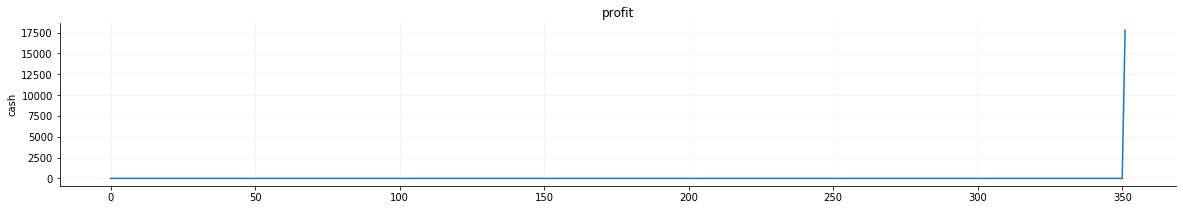

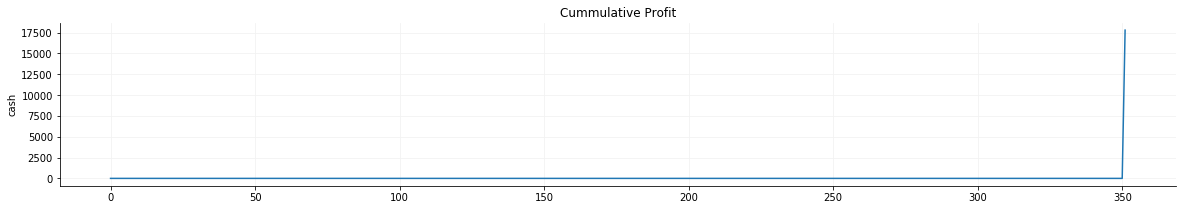

In [433]:
from sklearn import svm
from collections import Counter
from sklearn import metrics

profitper = []

clf = svm.SVC(kernel = 'linear')
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('accuracy:',confidence)
predictions = clf.predict(X_test)
print('predicted class counts:',Counter(predictions))
print('actual class counts:',Counter(y_test))
#print(metrics.classification_report(y_test, predictions))

profitper.append(sim(predictions)/1000)

accuracy: 0.5413105413105413
predicted class counts: Counter({0: 208, 1: 143})
actual class counts: Counter({0: 187, 1: 164})
119004.98039999997
19004.980399999968


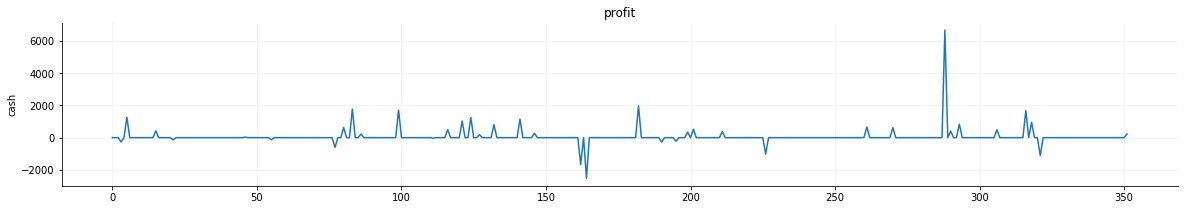

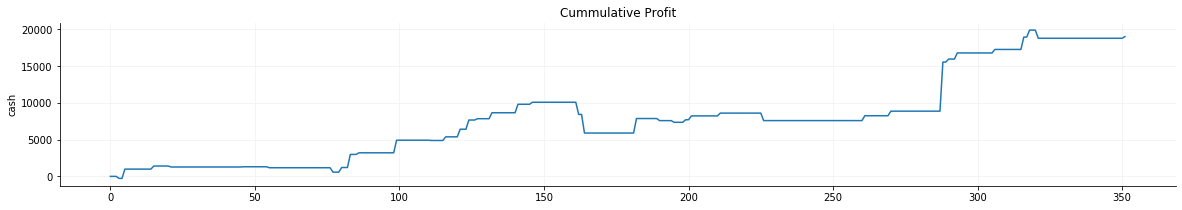

In [434]:
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('accuracy:',confidence)
predictions = clf.predict(X_test)
print('predicted class counts:',Counter(predictions))
print('actual class counts:',Counter(y_test))
#print(metrics.classification_report(y_test, predictions))

profitper.append(sim(predictions)/1000)

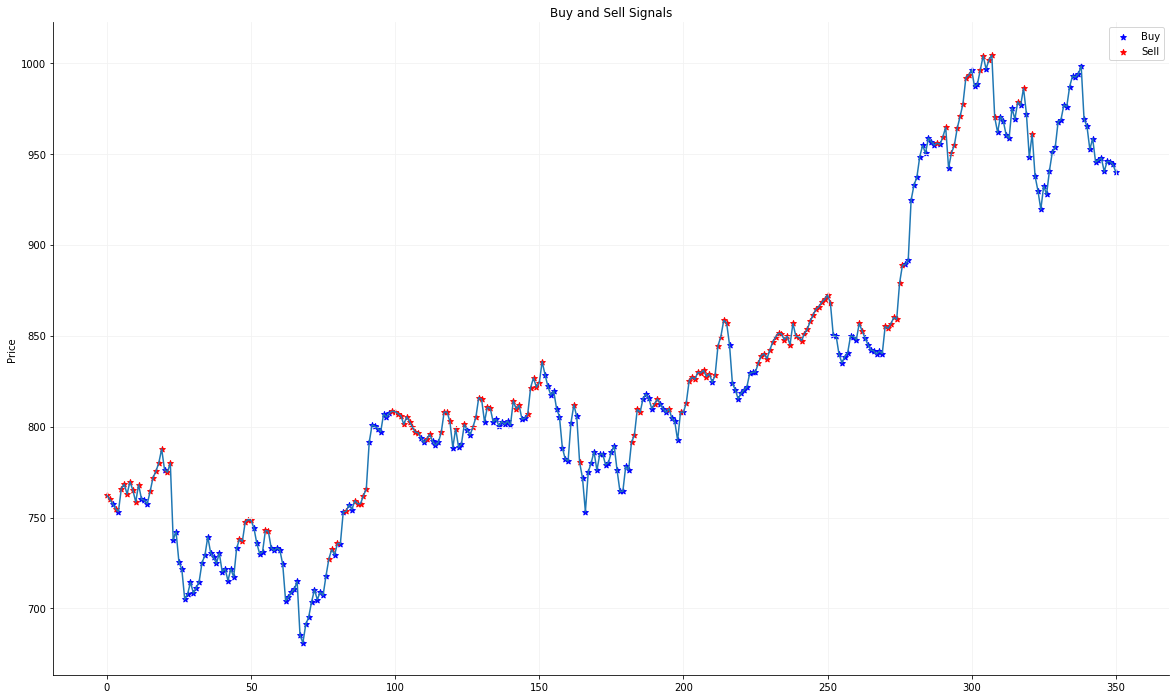

In [435]:
fig,ax = plt.subplots(figsize=(20,12))
plt.plot(temp)

buy_signal = []
buy_idx = []
sell_signal = []
sell_idx = []

for idx in range(len(predictions)):
    if(predictions[idx] == 0):
        buy_signal.append(temp[idx])
        buy_idx.append(idx)
    else:
        sell_signal.append(temp[idx])
        sell_idx.append(idx)
        
        

plt.scatter(buy_idx, buy_signal, color = 'blue', label='Buy',marker="*")
plt.scatter(sell_idx, sell_signal, color = 'red', label='Sell',marker="*")
plt.title("Buy and Sell Signals")
plt.ylabel("Price")
plt.legend()

accuracy: 0.5014245014245015
predicted class counts: Counter({1: 209, 0: 142})
actual class counts: Counter({0: 187, 1: 164})
107075.98279999998
7075.982799999999


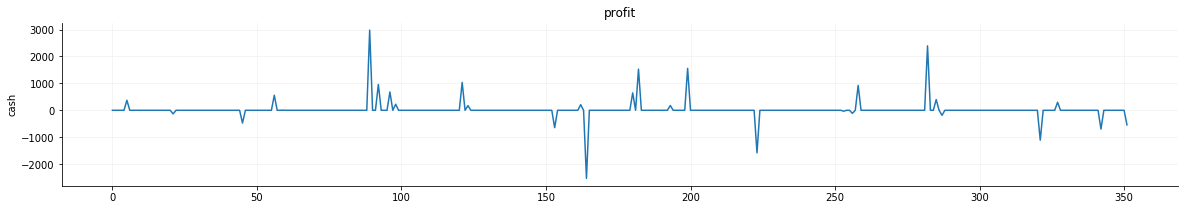

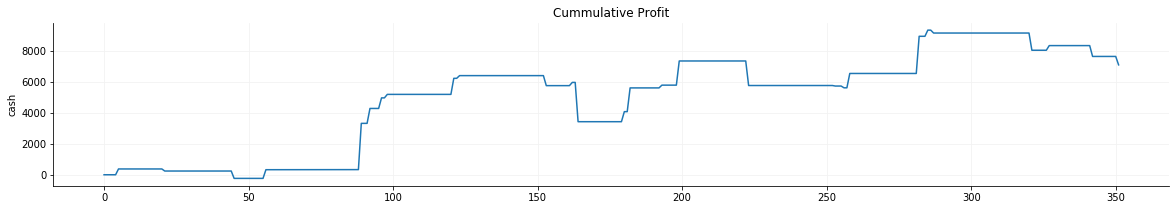

In [436]:
clf = svm.SVC(kernel = 'poly')
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('accuracy:',confidence)
predictions = clf.predict(X_test)
print('predicted class counts:',Counter(predictions))
print('actual class counts:',Counter(y_test))
#print(metrics.classification_report(y_test, predictions))

profitper.append(sim(predictions)/1000)
#sim(predictions)

[17.7920044, 19.00498039999997, 7.0759827999999985]


Text(0.5, 1.0, 'SVC Kernel Comparision')

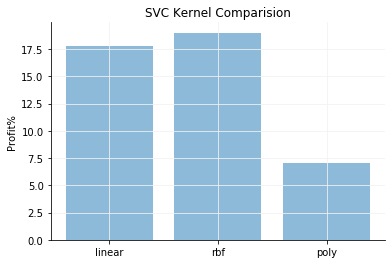

In [437]:
print(profitper)

objects = ('linear', 'rbf', 'poly')
y_pos = np.arange(len(objects))

plt.bar(y_pos, profitper, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Profit%')
plt.title('SVC Kernel Comparision')

In [438]:
#print(temp)
cash = 100000
stocks = 100


profit = (temp[len(temp)-1] - temp[0])*stocks
#print(temp[len(temp)-1])
#print(temp[0])
cash += profit

print(profit)
print(cash)

17792.004399999998
117792.0044


43.3048433048433
89148.0354000001
-10851.96459999985


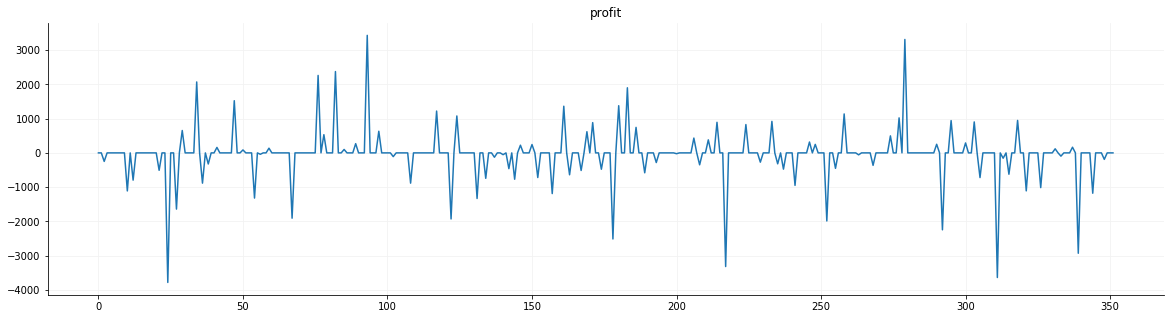

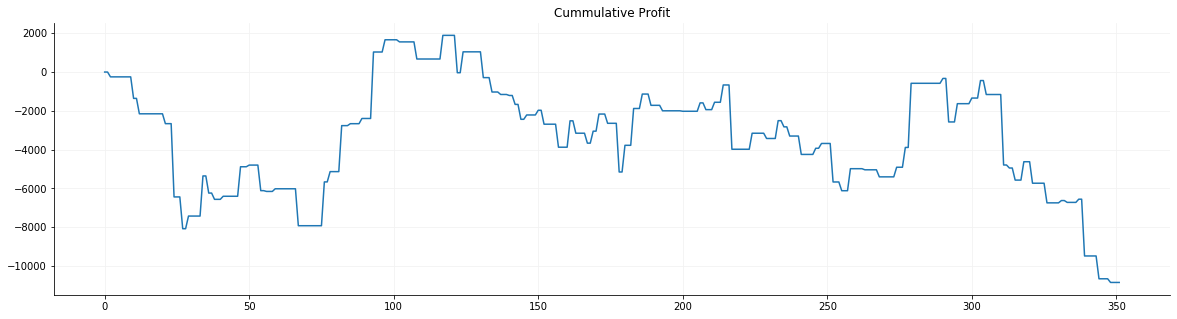

In [321]:
#print(np.random.rand(len(predictions)) // 2)
a = np.random.randint(0,2,(len(predictions)))
#print('actual class counts:',Counter(a))
print(accuracy(y_test, a))

sim(a)